In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import scipy
import scipy.io

import seaborn as sns
import matplotlib.pyplot as plt

from rpy2.robjects import r
from rpy2.robjects import pandas2ri

import anndata2ri

pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

During startup - Warning message:
Setting LC_CTYPE failed, using "C" 


In [2]:
%%R
suppressPackageStartupMessages({
    library(SingleCellExperiment)
    library(Seurat)
    library(Signac)
})


    consider that it could be called from a Python process. This
    results in a quasi-obligatory segfault when rpy2 is evaluating
    R code using it. On the hand, rpy2 is accounting for the
    fact that it might already be running embedded in a Python
    process. This is why:
    - Python -> rpy2 -> R -> reticulate: crashes
    - R -> reticulate -> Python -> rpy2: works

    The issue with reticulate is tracked here:
    https://github.com/rstudio/reticulate/issues/208
    

# Expressions

In [3]:
rna = sc.read('../../../data/10xpbmc10k-2020/expressions_hvg.h5ad')
rna

AnnData object with n_obs × n_vars = 10000 × 4000
    obs: 'cell_type'
    layers: 'count'

In [4]:
adata_ = ad.AnnData(rna.layers['count'])
adata_.obs_names = rna.obs_names
adata_.var_names = rna.var_names
adata_.obs['cell_type'] = rna.obs['cell_type']

In [5]:
%%R -i adata_
rna = as.Seurat(adata_, counts='X', data=NULL)
rna

An object of class Seurat 
4000 features across 10000 samples within 1 assay 
Active assay: originalexp (4000 features, 0 variable features)


# Peaks

In [6]:
atac = sc.read('../../../data/10xpbmc10k-2020/peaks.h5ad')
atac

AnnData object with n_obs × n_vars = 10000 × 40086
    obs: 'cell_type'
    layers: 'binary', 'cpm_norm', 'tf-idf'

In [7]:
adata_ = ad.AnnData(atac.layers['binary'])
adata_.obs_names = atac.obs_names
adata_.var_names = atac.var_names
adata_.obs['cell_type'] = atac.obs['cell_type']

In [8]:
%%R -i adata_
peaks = as.Seurat(adata_, counts='X', data=NULL)
peaks

An object of class Seurat 
40086 features across 10000 samples within 1 assay 
Active assay: originalexp (40086 features, 0 variable features)


# Run Seurat v4 WNN
Following https://satijalab.org/seurat/v4.0/weighted_nearest_neighbor_analysis.html.

In [10]:
%%R
rna <- RenameAssays(rna, originalexp="RNA")
bm <- rna
bm[["ATAC"]] <- CreateAssayObject(counts = peaks@assays$originalexp@counts)

print('Preprocessing RNA...')
DefaultAssay(bm) <- "RNA"
bm <- SCTransform(bm, variable.features.n = 4000, verbose=FALSE)
bm <- RunPCA(bm, verbose=FALSE)

R[write to console]: Renaming default assay from originalexp to RNA



[1] "Preprocessing RNA..."


In [11]:
%%R
print('Preprocessing ATAC...')
DefaultAssay(bm) <- "ATAC"
bm <- RunTFIDF(bm, verbose=FALSE)
bm <- FindTopFeatures(bm, min.cutoff = 'q0', verbose=FALSE)
bm <- RunSVD(bm, verbose=FALSE)

[1] "Preprocessing ATAC..."


In [13]:
%%R
bm <- FindMultiModalNeighbors(bm, reduction.list = list("pca", "lsi"), 
                              dims.list = list(1:50, 2:50), modality.weight.name = "RNA.weight", verbose=FALSE)

bm <- RunSPCA(bm, assay = 'SCT', graph = 'wsnn', npcs = 20, verbose=FALSE)

R[write to console]: Error in x$.self$finalize() : attempt to apply non-function

R[write to console]: Error in x$.self$finalize() : attempt to apply non-function



In [14]:
%%R -o spca
spca = Embeddings(object = bm[["spca"]])

In [15]:
adata = sc.AnnData(spca)
adata.obs = adata_.obs
adata

AnnData object with n_obs × n_vars = 10000 × 20
    obs: 'cell_type'

In [16]:
%%R -o wnn
wnn <- as.data.frame(summary(bm@graphs$wknn))

In [17]:
wnn['i'] = wnn['i'] - 1
wnn['j'] = wnn['j'] - 1

In [18]:
adata.obsp['wnn_connectivities'] = scipy.sparse.coo_matrix((wnn['x'], (wnn['i'], wnn['j'])))
adata.obsp['wnn_connectivities'] = scipy.sparse.csr_matrix(adata.obsp['wnn_connectivities'])

In [19]:
adata.write('10x-seurat.h5ad')

# Visualize results

In [20]:
sc.pp.neighbors(adata)
adata.obsp['connectivities'] = adata.obsp['wnn_connectivities'].copy()
# delete distances to make sure we are not using anything calculated with sc.pp.neighbors()
del adata.obsp['distances']
sc.tl.umap(adata)

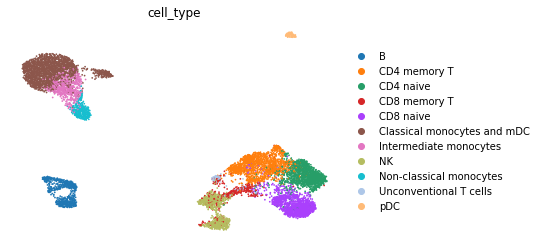

In [22]:
sc.pl.umap(adata, color=['cell_type'], ncols=1, frameon=False, save='10x-seurat.png')

In [23]:
%%R
sessionInfo()

R version 4.1.3 (2022-03-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /lustre/groups/ml01/workspace/anastasia.litinetskaya/miniconda3/envs/bridge/lib/libopenblasp-r0.3.20.so

locale:
 [1] LC_CTYPE=C                 LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    tools     stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] Matrix_1.4-1                Signac_1.7.0               
 [3] sp_1.5-0                    SeuratObject_4.1.0         
 [5] Seurat_4.1.1.9001           SingleCellExperiment_1.16.0
 [7] SummarizedExperiment_1.24.0 Biobase_2.54.0       